In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

### Bayesian EM for Mixture of two gaussians

Implementation of the markup chain Monte Carlo algorithm for
fitting a location mixture of two univariate Gaussian  distributions.

In [2]:
### Example of an EM algorithm for fitting a location mixture of 2 Gaussian components
### The algorithm is tested using simulated data

from scipy.stats import norm

## Clear the environment and load required libraries
np.random.seed(1)

## Generate data from a mixture with 2 components
KK         = 2 # Number of componentes
w_true     = [0.6, 0.4]  # True weights associated with the components
mu_true    = [0, 5]   # True mean for the first and secondcomponent
sigma_true = [1, 1]   # True standard deviation of all components
n          = 120         # Number of observations to be generated
### Step 1 ### Sample component indicators
cc_true    = np.random.choice([0, 1], n, p = w_true) # C_i sample 
x     = []
### Step 2 ### Sample from normal distribution
for i in range(n):
  x.append(norm.rvs(loc = mu_true[cc_true[i]], scale = sigma_true[cc_true[i]], size = 1)[0])

x = np.array(x)
print('The first five samples of C_i are: {}'.format(cc_true[:5]))
print('The first five samples of the mixture are: {}'.format(x[:5]))

The first five samples of C_i are: [0 1 0 0 0]
The first five samples of the mixture are: [ 0.12182127  6.12948391  1.19891788  0.18515642 -0.37528495]


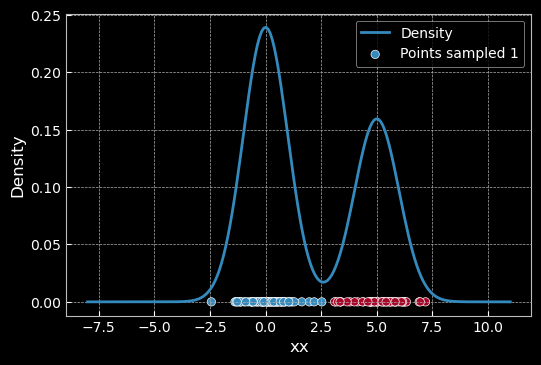

In [3]:
### Plotting the true distributions

# Plot f(x) along with the observations just sampled

# Values to sample
xx_true = np.linspace(-8, 11.0, num = 200)

yy_true = w_true[0] * norm.pdf(loc = mu_true[0], scale = sigma_true[0], x = xx_true) + w_true[1] * norm.pdf(loc = mu_true[1], scale = sigma_true[1], x = xx_true)

# Plotting the mixture models
fig, ax = plt.subplots(1, 1)
sns.lineplot(xx_true, yy_true)
sns.scatterplot(np.array(x), np.zeros(len(x)), hue = cc_true)
plt.xlabel('xx')
plt.ylabel('Density')
plt.legend(['Density', 'Points sampled 1'])
plt.show()

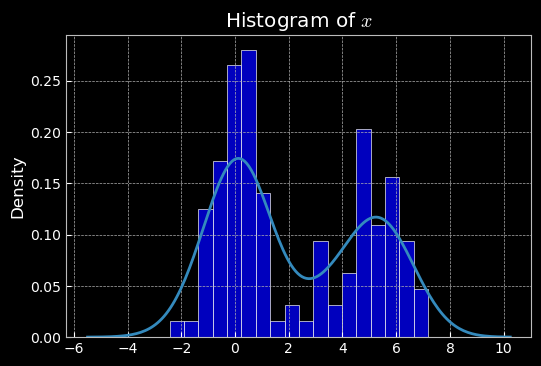

In [4]:
# Density estimation of X
fig, ax = plt.subplots(1, 1)
sns.histplot(x, stat= 'density', bins = 18)
sns.kdeplot(x, bw_adjust = 1.0, label = 'Density estimate $x$')
plt.title('Histogram of $x$')
plt.show()

### Initial guess of data

The initial guess for mu are: [6.52666313 0.62053546]
The initial guess for sigma are: 2.6412606675636803


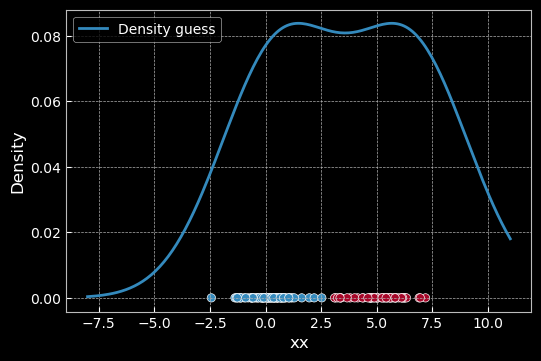

In [5]:
## Initialize the parameters
w     = 0.5                         # Assign equal weight to each component to start with
mu    = norm.rvs(loc = np.mean(x), scale = np.std(x), size = KK, random_state = 1) # Random cluster centers randomly spread over the support of the data
sigma = np.std(x)                   # Initial standard deviation

print('The initial guess for mu are: {}'.format(mu))
print('The initial guess for sigma are: {}'.format(sigma))

# Values to sample
xx = np.linspace(-8, 11.0, num = 200)
yy = w * norm.pdf(loc = mu[0], scale = sigma, x = xx) + w * norm.pdf(loc = mu[1], scale = sigma, x = xx)

# Plot the initial guess for the density
fig, ax = plt.subplots(1, 1)
sns.lineplot(xx, yy)
sns.scatterplot(np.array(x), np.zeros(len(x)), hue = cc_true)
plt.xlabel('xx')
plt.ylabel('Density')
plt.legend(['Density guess'])
plt.show()

### Initializing priors

In [6]:
## The actual MCMC algorithm starts here
# Priors
aa  = np.ones(KK)  # Uniform prior on w
eta = 0          # Mean 0 for the prior on mu_k
tau = 5          # Standard deviation 5 on the prior for mu_l
dd  = 2          # Inverse gamma prior for sigma_2, parameter d
qq  = 1          # Inverse gamma prior for sigma_2, parameter q

Current iteration is: 0
Current iteration is: 500
Current iteration is: 1000
Current iteration is: 1500
Current iteration is: 2000
Current iteration is: 2500
Current iteration is: 3000
Current iteration is: 3500
Current iteration is: 4000
Current iteration is: 4500
Current iteration is: 5000
Current iteration is: 5500


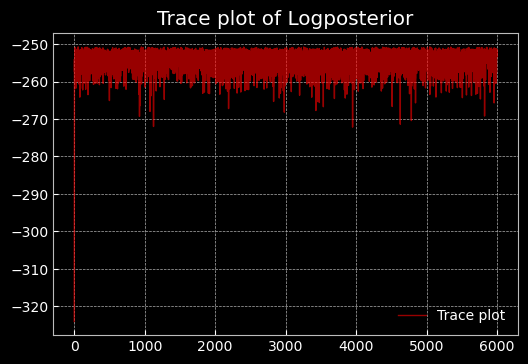

In [7]:
from scipy.stats import beta
from scipy.stats import invgamma
from scipy.stats import beta

# Number of iterations of the sampler
rrr   = 6000 # Number of iterations
burn  = 1000 # Burning period

# Storing the samples
cc_out    = np.zeros((rrr, n))    # Store indicators
w_out     = np.zeros(rrr)         # Sample of the weights
mu_out    = np.zeros((rrr, KK))   # Sample of mus
sigma_out = np.zeros(rrr)         # Sample of sigmas
logpost   = np.zeros(rrr)         # Used to monitor convergence

for s in range(rrr):
  # Sample the indicators
  cc = np.zeros(n)
  for i in range(n):
    v = np.zeros(KK)
    v[0]  = np.log(w) + norm.logpdf(loc = mu[0], scale = sigma, x = x[i])    # Compute the log of the weights
    v[1]  = np.log(1 - w) + norm.logpdf(loc = mu[1], scale = sigma, x = x[i])  # Compute the log of the weights
    v     = np.exp(v - max(v)) / np.sum(np.exp(v - max(v)))  # Go from logs to actual weights in a numerically stable manner
    cc[i] = np.random.choice([0, 1], 1, p = v) # C_i sample 

  # Sample the weights
  w = beta.rvs(a = aa[0] + np.sum(cc == 0), b = aa[1] + np.sum(cc == 1), size = 1)

  # Sample the means
  for k in range(KK):
    nk    = np.sum(cc == k)
    xsumk = np.sum(x[cc == k])
    tau2_hat = 1 / (nk / sigma**2 + 1 / tau**2)
    mu_hat  = tau2_hat * (xsumk / sigma**2 + eta / tau**2)
    mu[k]   = norm.rvs(loc = mu_hat, scale = np.sqrt(tau2_hat), size = 1)

  # Sample the variances
  dd_star = dd + n / 2
  mu_temp = [mu[int(c_i)] for c_i in cc] # Create vector of mus
  qq_star = qq + np.sum((x - mu_temp)**2) / 2
  sigma = np.sqrt(invgamma.rvs(a = dd_star, scale = qq_star, size = 1)) 

  # Store samples
  cc_out[s, :]   = cc
  w_out[s]       = w
  mu_out[s, :]   = mu
  sigma_out[s]   = sigma

  for i in range(n):
    # Computing logposterior likelihood term
    if cc[i] == 0:
      logpost[s] = logpost[s] + np.log(w) + norm.logpdf(loc = mu[0], scale = sigma, x = x[i])
    else: 
      logpost[s] = logpost[s] + np.log(1 - w) + norm.logpdf(loc = mu[1], scale = sigma, x = x[i])

  # W term
  logpost[s] = logpost[s] + beta.logpdf(a = aa[0], b = aa[1], x = w)
  # Mu term
  for k in range(KK):
    logpost[s] = logpost[s] + norm.logpdf(loc = eta, scale = tau, x = mu[k])
  # Sigma term
  logpost[s] = logpost[s] + invgamma.logpdf(a = dd, scale = 1 / qq, x = sigma**2)
  if s / 500 == np.floor(s / 500):
    print('Current iteration is: {}'.format(s))

## Plot the logposterior distribution for various samples
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(logpost)), logpost, 'r-', lw=1, alpha=0.6, label='Trace plot') # Trace plot of data
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Trace plot of Logposterior')
plt.show()

In [8]:
print('The final Mu_hat values are: {}'.format(mu))
print('The true mu values are: {}\n'.format(mu_true))

print('The final sigma_hat values are: {}'.format(sigma))
print('The true sigma values are: {}\n'.format(sigma_true))

print('The final w_hat values are: {}'.format(w))
print('The true w values are: {}\n'.format(w_true))

print('The final c_hat values are: {}'.format(cc[:10]))
print('The true c values are: {}\n'.format(cc_true[:10]))

The final Mu_hat values are: [5.1900598  0.29016343]
The true mu values are: [0, 5]

The final sigma_hat values are: [0.9182188]
The true sigma values are: [1, 1]

The final w_hat values are: [0.49238716]
The true w values are: [0.6, 0.4]

The final c_hat values are: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
The true c values are: [0 1 0 0 0 0 0 0 0 0]



In [9]:
# Values to sample
xx = np.linspace(-8, 11.0, num = 200)
density_posterior = np.zeros((rrr-burn, len(xx)))
for s in range(rrr-burn):
  density_posterior[s, :] = density_posterior[s, :] + \
                             w_out[s + burn] * norm.pdf(loc = mu_out[s + burn, 0], scale = sigma_out[s + burn], x = xx) + \
                             (1 - w_out[s + burn]) * norm.pdf(loc = mu_out[s + burn, 1], scale = sigma_out[s + burn], x = xx)

density_posterior_m = np.mean(density_posterior, axis = 0)
density_posterior_lq = np.quantile(density_posterior, 0.025, axis = 0)
density_posterior_uq = np.quantile(density_posterior, 0.975, axis = 0)

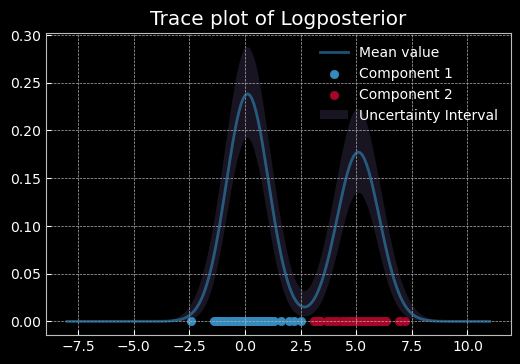

In [10]:
## Plot the final result distribution for various samples
fig, ax = plt.subplots(1, 1)
# Mean value
ax.plot(xx, density_posterior_m,  lw=2, alpha=0.6, label='Mean value') # Trace plot of data
# Plotting original data
for k in range(KK):
  ax.scatter(np.array(x[cc_true == k]), np.zeros((x[cc_true == k].shape[0])), label = 'Component {}'.format(k + 1))
# Plotting uncertainty
plt.fill_between(xx, density_posterior_uq, density_posterior_lq, alpha=0.2,
                 label='Uncertainty Interval')
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Trace plot of Logposterior')
plt.show()